In [1]:
import base

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import notebook as tqdm

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from sklearn.metrics import mean_absolute_error

from tslearn.svm import TimeSeriesSVR

from transformers_sig import AddTime, LeadLag

from sigKer_fast import sig_kernel_Gram_matrix 

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

In [3]:
#Helper function that extract rolling windows of historical prices of size h and means of the next future f prices.
def GetWindow(x, h_window=30, f_window=10):

    # First window
    X = np.array(x.iloc[:h_window,]).reshape(1,-1)
   
    # Append next window
    for i in range(1,len(x)-h_window+1):
        x_i = np.array(x.iloc[i:i+h_window,]).reshape(1,-1)
        X = np.append(X, x_i, axis=0)
        
    # Cut the end that we can't use to predict future price
    rolling_window = (pd.DataFrame(X)).iloc[:-f_window,]
    return rolling_window

def GetNextMean(x, h_window=30, f_window=10):
    return pd.DataFrame((x.rolling(f_window).mean().iloc[h_window+f_window-1:,]))

In [150]:
def PlotResult(y_train, y_test, y_train_predict, y_test_predict, name, error_train, error_test, p_error_train, p_error_test):
    
    train_len = len(y_train)
    test_len = len(y_test)
            
    #Visualise
    fig, ax = plt.subplots(1, figsize=(12, 5))
    ax.plot(y_train_predict,color='red')

    ax.plot(range(train_len, train_len+test_len),
            y_test_predict,
            label='Predicted average price',
            color='red',linestyle = '--')

    ax.plot(np.array((y_train).append(y_test)),
             label='Actual average price',
             color='green')

    ax.axvspan(len(y_train), len(y_train)+len(y_test),
                alpha=0.3, color='lightgrey')
    
    ax.plot([], [], ' ', label='\ntrain:  MAE={0:.3f}  MAPE={1:.3f}%'.format(error_train, p_error_train))
    ax.plot([], [], ' ', label='test:   MAE={0:.3f}  MAPE={1:.3f}%'.format(error_test, p_error_test))

    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best")
    plt.savefig('../pictures/bitcoin_prices_prediction_{}'.format(name))
    plt.show()

In [5]:
#data is from https://www.cryptodatadownload.com/
BTC_price = pd.read_csv('../data/gemini_BTCUSD_day.csv',header=1)
# BTC_price = pd.read_csv('../data/gemini_BTCUSD_2020_1min.csv',header=1)

In [6]:
#drop the first column and reverse order
BTC_price = BTC_price.iloc[1:,:]
BTC_price = BTC_price.iloc[::-1]
BTC_price['Date'] = pd.to_datetime(BTC_price['Date'])
BTC_price.set_index('Date', inplace=True)

In [83]:
#select duration
initial_date = '2017-06-01'
finish_date = '2018-06-01'
BTC_price_time = BTC_price[initial_date:finish_date]

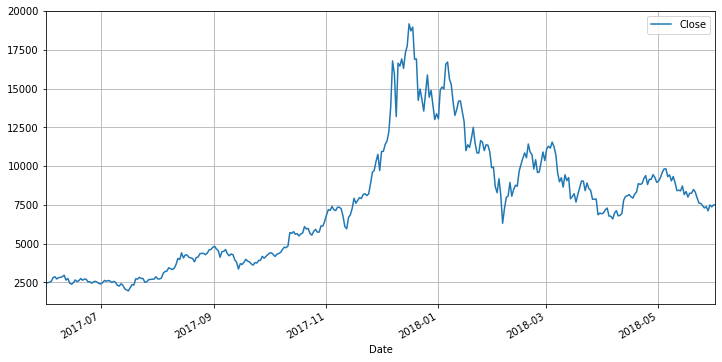

In [114]:
ax = BTC_price_time.plot(y= 'Close', figsize=(12,6), legend=True, grid=True, use_index=True)
plt.show()

In [9]:
# We use only close price
close_price = BTC_price_time.loc[:,'Close']
close_price = TimeSeriesScalerMeanVariance().fit_transform(close_price.values[None,:])
close_price = pd.DataFrame(np.squeeze(close_price))

In [10]:
h_window = 30
f_window = 10

In [11]:
# mean next price
y = GetNextMean(close_price, h_window = h_window , f_window = f_window)

In [12]:
# normal window features
X_window = GetWindow(close_price, h_window, f_window).values
X_window = np.array(LeadLag().fit_transform(X_window))
X_window = np.array(AddTime().fit_transform(X_window))

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X_window, y, test_size=0.2, shuffle=False)

In [14]:
n, solver = 0, 0

In [73]:
gram_matrix = sig_kernel_Gram_matrix(x_train, x_train, n, solver, sym=True, rbf=True, sigma=2.5e1)

In [74]:
test_matrix = sig_kernel_Gram_matrix(x_train, x_test, n, solver, sym=False, rbf=True, sigma=2.5e1)

In [75]:
svr_parameters = {'C': np.logspace(0, 3, 5), 'gamma': np.logspace(-3, 3, 7)}

In [78]:
kernels = ['rbf', 'precomputed', 'gak']

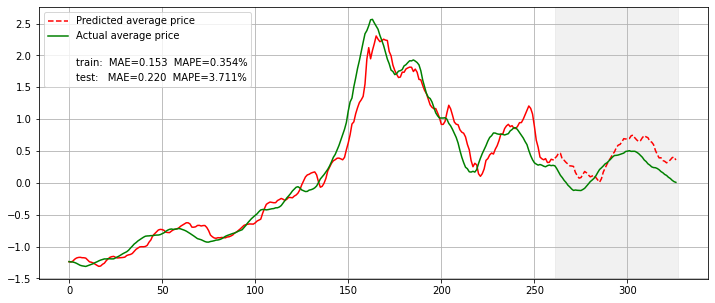

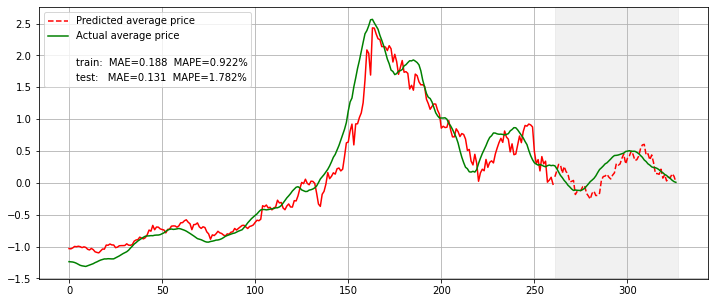

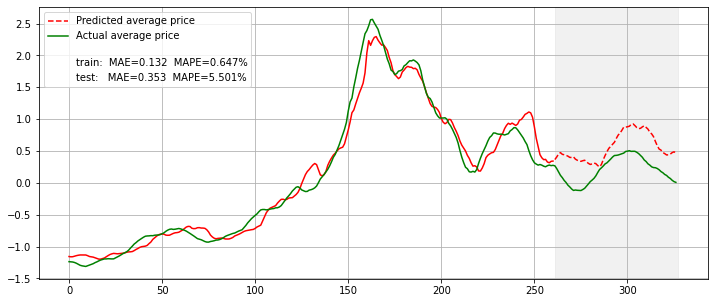

In [151]:
for ker in tqdm.tqdm(kernels):
    
    svr = TimeSeriesSVR(kernel=ker)

    svr_model = GridSearchCV(estimator=svr, 
                             param_grid=svr_parameters, 
                             cv=TimeSeriesSplit(n_splits=5),
                             n_jobs=-1)

    if ker=='precomputed':
        svr_model.fit(gram_matrix, np.squeeze(y_train))
        y_train_predict = svr_model.predict(gram_matrix.T)
        y_test_predict = svr_model.predict(test_matrix.T)
        name = 'sig-PDE'
    
    else:
        svr_model.fit(x_train, np.squeeze(y_train))
        y_train_predict = svr_model.predict(x_train)
        y_test_predict = svr_model.predict(x_test)
        name = ker

    # calculate errors
    error_train = mean_absolute_error(y_train, y_train_predict)        
    error_test = mean_absolute_error(y_test, y_test_predict)
    p_error_train = mean_absolute_percentage_error(np.array(y_train).reshape(-1,1), np.array(y_train_predict).reshape(-1,1))
    p_error_test = mean_absolute_percentage_error(np.array(y_test).reshape(-1,1), np.array(y_test_predict).reshape(-1,1))
    
    PlotResult(y_train, y_test, y_train_predict, y_test_predict, f'SVR + {name}', 
               error_train, error_test, p_error_train, p_error_test)